<a href="https://colab.research.google.com/github/kmehta96/Multiclass_weather/blob/master/Mulit_weather_predition_usingVGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
import glob 
import re
import cv2
import tensorflow as tf
from keras.utils import to_categorical
from keras import applications
from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential
from keras.layers import Flatten,Dense,Dropout


#Import Data

In [ ]:
#Import Dataset from github profile
import requests, zipfile, io
r = requests.get( 'https://github.com/kmehta96/Multiclass_weather/blob/master/Dataset.zip?raw=true' ) 
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [ ]:
#Unzip Dataset
!unzip /content/dataset2.zip

Archive:  /content/dataset2.zip
replace dataset2/cloudy1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: dataset2/cloudy1.jpg    
replace dataset2/cloudy10.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace dataset2/cloudy100.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
#Assign path using os library
path = os.path.dirname('/content/dataset2/')

In [ ]:
#Read Input Features
features=[]
images = glob.glob(path+'/*.*')
error_set=set()
for i in range(len(images)): 
  image = cv2.imread(images[i])
  try : 
      image = cv2.resize(image, (224,224))
      image = tf.keras.preprocessing.image.img_to_array(image)
      features.append(image)
  except :
      print('Error while reading file with file name: %s'%images[i]) 
      error_set.add(images[i].split('/')[-1])
      pass
features=np.array(features)

Error while reading file with file name: /content/dataset2/shine131.jpg
Error while reading file with file name: /content/dataset2/rain141.jpg


In [ ]:
#Read File Name & store to labels array
re_compile = re.compile("([a-zA-Z]+)") 
label_arr=[]
for img_filename in os.listdir(path):
  if img_filename.endswith(".jpg") or img_filename.endswith(".jpeg"):
    if img_filename in error_set:
        continue
    name_tupple = re_compile.match(img_filename).groups()
    label_arr.append(name_tupple[0])
  else:
    print('Error different file format found',img_filename)
labels=np.array(label_arr)

In [ ]:
print('Total Number of Images: %s'%features.shape[0])
print('Size of Input Image: %s x %s'%(features.shape[1],features.shape[2]))
try:
  print('Type of Image: RGB') if features.shape[3]==3 else ""
except:
  print('Type of Image: Grayscale')

Total Number of Images: 1123
Size of Input Image: 224 x 224
Type of Image: RGB


In [ ]:
#Distribution of Images per classes
pd.DataFrame(labels)[0].value_counts()

sunrise    357
cloudy     300
shine      252
rain       214
Name: 0, dtype: int64

In [ ]:
#Label encoding
dict_={'sunrise':0,'cloudy':1,'shine':2,'rain':3}
label_dict = {0: 'sunrise', 1: 'cloudy',2: 'shine', 3: 'rain'}
label = np.vectorize(dict_.get)(labels)

In [ ]:
images_reshaped = features.reshape((-1, 224, 224,3))
labels_reshaped = to_categorical(label, num_classes=4)

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(images_reshaped,labels_reshaped,test_size=0.2,random_state=1)

# Model Development

##VGG16

In [ ]:
model_vgg = applications.VGG16(include_top=False,weights='imagenet')
model_vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [ ]:
model_vgg = Sequential()  
model_vgg.add(Flatten(input_shape=X_train.shape[1:]))  
model_vgg.add(Dense(256, activation='relu'))  
model_vgg.add(Dropout(0.5))  
model_vgg.add(Dense(4, activation='softmax'))  #Output Layer
   
model_vgg.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])  
   
history = model_vgg.fit(X_train, Y_train,  
          epochs=50,  
          batch_size=16,  
          validation_data=(X_test, Y_test))  
   
model_vgg.save_weights('top_model_weights.h5')  

Train on 898 samples, validate on 225 samples
Epoch 1/50
898/898 [==============================] - 26s 29ms/step - loss: 6816.1419 - accuracy: 0.6514 - val_loss: 6114.5927 - val_accuracy: 0.7200
Epoch 2/50
898/898 [==============================] - 25s 28ms/step - loss: 5017.3444 - accuracy: 0.7316 - val_loss: 2898.6526 - val_accuracy: 0.7822
Epoch 3/50
898/898 [==============================] - 25s 27ms/step - loss: 4146.1699 - accuracy: 0.7316 - val_loss: 3193.1567 - val_accuracy: 0.7911
Epoch 4/50
898/898 [==============================] - 24s 27ms/step - loss: 4098.8448 - accuracy: 0.7940 - val_loss: 3699.7756 - val_accuracy: 0.7689
Epoch 5/50
898/898 [==============================] - 25s 27ms/step - loss: 2833.9402 - accuracy: 0.7951 - val_loss: 2512.8848 - val_accuracy: 0.8178
Epoch 6/50
898/898 [==============================] - 25s 27ms/step - loss: 3623.4583 - accuracy: 0.7884 - val_loss: 2778.7794 - val_accuracy: 0.8178
Epoch 7/50
898/898 [==============================] - 

NameError: ignored

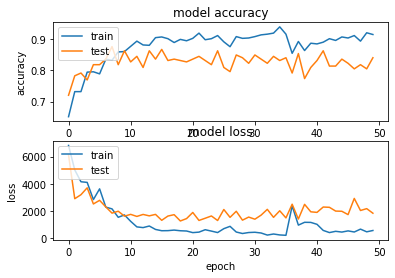

In [ ]:
 plt.figure(1)  
   
 # summarize history for accuracy  
   
 plt.subplot(211)  
 plt.plot(history.history['accuracy'])  
 plt.plot(history.history['val_accuracy'])  
 plt.title('model accuracy')  
 plt.ylabel('accuracy')  
 plt.xlabel('epoch')  
 plt.legend(['train', 'test'], loc='upper left')  
   
 # summarize history for loss  
   
 plt.subplot(212)  
 plt.plot(history.history['loss'])  
 plt.plot(history.history['val_loss'])  
 plt.title('model loss')  
 plt.ylabel('loss')  
 plt.xlabel('epoch')  
 plt.legend(['train', 'test'], loc='upper left')  
 plt.show() 

In [ ]:
def load_img(path):
    image_path = path

    orig = cv2.imread(image_path)  
    plt.imshow(orig)
    image = cv2.resize(orig, (224,224))  
    image = tf.keras.preprocessing.image.img_to_array(image)  
    image = np.expand_dims(image, axis=0)
    return image

In [ ]:
def predict_img(image):
    # build the VGG16 network  
    class_predicted = model_vgg.predict_classes(image)
    return label_dict[class_predicted[0]]

'shine'

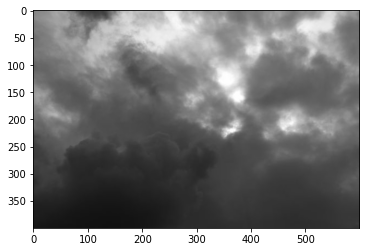

In [ ]:
predict_img(load_img('/content/dataset2/cloudy1.jpg'))

'cloudy'

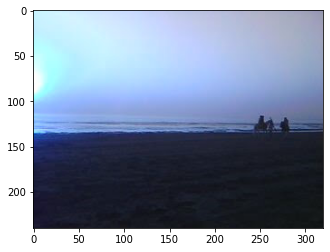

In [ ]:
predict_img(load_img('/content/IMG0265A.jpg'))

'shine'

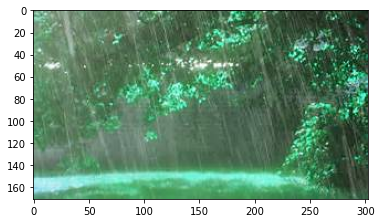

In [ ]:
predict_img(load_img('/content/dataset2/rain215.jpg'))

'shine'

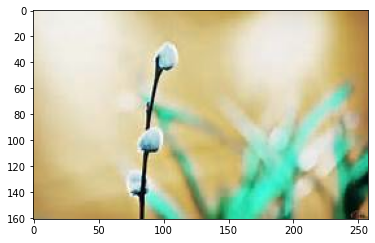

In [ ]:
predict_img(load_img('/content/dataset2/shine152.jpg'))
